In [1]:
#import sys
#sys.path.append('C:\\Users\\mabdalla\\OneDrive - ec-lyon.fr\\Documents\\Python Scripts\\packages')
import torch
import numpy as np
import photontorch as pt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from photontorch.environment import current_environment
#import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import butter#, lfilter
import pandas as pd 
from photontorch import BoundedParameter
from ipywidgets import interact
from tqdm.notebook import trange
torch.__version__

'1.6.0'

### Components: Mask

In [2]:
class mask(pt.Component):
    """
    A masking signal that is either binary or from a standard distribution.

    Terms: 
        0 ---- 1 
    
    """       
    num_ports = 2
    
    def __init__(
        self,
        m_length = 5,
        mask_vector=torch.ones(5),
        name=None,
    ):
        
        super(mask,self).__init__(name=name)
        self.m_length = int(m_length)
        self.mask_vector = mask_vector
        self.counter = -1
        
        #print(x)
        
        
    def action(self,t,x_in,x_out):
        a_in, _ = x_in
        
        x_out[0] = a_in  #Nothing happens to input node        
        
        self.counter = self.counter + 1
            
        x_out[1] = a_in * self.mask_vector[self.counter]
        #print(x_out[1])
        if self.counter == self.m_length-1:
            self.counter = -1
            
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self,S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

### Constructing the Reservoir Circuit

In [3]:
class dc_reservoir(pt.Network):
    def __init__(self, wg_delay=1e-9, wg_phase=0, ring_per=2*np.pi*6.75e-6, tr=0.9, loss=200,
                 nodes=25, mask_vector=torch.ones(10, dtype=torch.float64), 
                 weights = 0.1*torch.rand(25, dtype=torch.float64),
                 neff = 2.2111, ng = 2.2637, mzi_l1=1e-3, mzi_l2=1e-3, mzi_fb = 3.88e-3):
        super(dc_reservoir, self).__init__()
        self.src = pt.Source()
        
        length=299792458*wg_delay/ng
        self.det = pt.Detector()
        self.mask = mask(m_length=nodes, mask_vector = mask_vector)
        self.term = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(length=mzi_l1, ng = ng, neff = neff, loss=loss)
        #self.wg2 = pt.Waveguide(length=length, ng = ng, neff = neff, loss=loss)
        #self.fb = pt.Waveguide(neff = neff, ng=ng, length=length-mzi_l2, phase=wg_phase, loss=loss)
        self.wg2 = pt.Waveguide(length=mzi_l2, ng = ng, neff = neff, loss=loss)
        self.fb = pt.Waveguide(neff = neff, ng=ng, length=mzi_fb, phase=wg_phase, loss=loss)
        self.link('src:0', '0:mask:1', '0:dc1:1', '0:wg1:1', '0:dc2:1', '0:det')
        self.link('dc2:2', '0:wg2:1', '3:dc1')
        self.link('dc2:3', '0:fb:1', '2:dc1')
        #print(self.graph(draw=True))
        #print(length-mzi_l2)

print(torch.where(dc_reservoir().free_ports_at)[0])


tensor([], dtype=torch.int64)


In [4]:
class dc_reservoir_freq(pt.Network):
    def __init__(self, wg_delay=1e-9, wg_phase=0, tr=0.9,
                 neff = 2.2111, ng = 2.2637, mzi_l1=1e-3, mzi_l2=1e-3, mzi_fb=3.88e-3, loss=200):
        super(dc_reservoir_freq, self).__init__()
        length=299792458*wg_delay/ng

        self.src = pt.Source()
        self.det = pt.Detector()
        self.term = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(length=mzi_l1, ng = ng, neff=neff, loss=loss)
        #self.wg2 = pt.Waveguide(length=length, ng = ng, neff=neff, loss=loss)
        #self.fb = pt.Waveguide(ng=ng, neff=neff, length=length-mzi_l2, phase=wg_phase, loss=loss)
        self.wg2 = pt.Waveguide(length=mzi_l2, ng = ng, neff = neff, loss=loss)
        self.fb = pt.Waveguide(neff = neff, ng=ng, length=mzi_fb, phase=wg_phase, loss=loss)
        self.link('src:0', '0:dc1:1', '0:wg1:1', '0:dc2:1', '0:det')
        self.link('dc2:2', '0:wg2:1', '3:dc1')
        self.link('dc2:3', '0:fb:1', '2:dc1')
        #print(self.graph(draw=True))
        #print(length-mzi_l2)

In [5]:
class mzi_response(pt.Network):
    def __init__(self, wg_delay=1e-9, wg_phase=0, tr=0.9,
                 neff = 2.2111, ng = 2.2637, mzi_l1=1e-3, mzi_l2=1e-3, loss=20):
        super(mzi_response, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.term1 = self.term2 = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(length=mzi_l1, ng = ng, neff=neff, loss=loss, phase=wg_phase)
        self.wg2 = pt.Waveguide(length=mzi_l2, ng = ng, neff=neff, loss=loss)
        self.link('src:0', '0:dc1:1', '0:wg1:1', '0:dc2:1', '0:det')
        self.link('term1:0', '3:dc2:2', '0:wg2:1', '3:dc1:2', '0:term2')

print(torch.where(dc_reservoir().free_ports_at)[0])

tensor([], dtype=torch.int64)


## Constructing Delay Line Reservoir

In [6]:
class delay_line(pt.Network):
    def __init__(self, wg_delay=1e-9, wg_phase=0,
                 nodes=25, mask_vector=torch.ones(10, dtype=torch.float64), 
                 weights = 0.1*torch.rand(25, dtype=torch.float64),
                 neff = 2.2111, ng = 2.2637):
        super(delay_line, self).__init__()
        length=299792458*wg_delay/ng
        self.src = pt.Source()
        self.det = pt.Detector()
        self.mask = mask(m_length=nodes, mask_vector = mask_vector)
        self.wg = pt.Waveguide(length=length, ng = ng, neff = neff, loss = 20)
        self.link('src:0', '0:mask:1', '0:wg:1', '0:det')
        #print(self.graph(draw=True))
print(torch.where(delay_line().free_ports_at)[0])

tensor([], dtype=torch.int64)


## Simulation Setup

In [7]:
'''------- Generate uniform distribution between 0 and 0.5 -------'''

class Narma10Generator(np.random.RandomState):
    def __call__(self, N, B=1):
        u = (0.5-0)*self.rand(N,B)
        return u

In [8]:
'''----- NARMA10 TASK -----'''

def narma10_jaeger(x):
    
    size = len(x)
    y = torch.zeros(x.shape)
    for n in range(10,size):
        y[n] = 0.3*y[n-1] + 0.05*y[n-1]*(y[n-1]+y[n-2]+y[n-3] \
            +y[n-4]+y[n-5]+y[n-6]+y[n-7]+y[n-8]+y[n-9]+y[n-10]) \
            + 1.5*x[n-10]*x[n-1] + 0.1
    return y

TARGET = narma10_jaeger 

In [9]:
'''----- SIMULATION PARAMETERS -----'''

# ----- General Parameters -----
c = 299792458.0                           #[m/s] speed of light
Rb = 1e9                                  #[1/s] bitrate
Rs = 35*Rb                                #[1/s] samplerate
fc = 2e9                                  #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9                             #[m] center wavelength
neff = 2.2111     #1.4440                 #[1] effective index of fiber spool
ng = 2.2637       #1.4626                 #[1] group index of fiber spool
neff_mzm = 2.2111                         #[1] Effective index of lithium niobate (modulator)
ng_mzm = 2.2637                           #[1] Group index of lithium niobate (modulator)
N = 3200                                  #[1] number of bits per bit stream
B = 1                                     #[1] Number of bit streams in training batch
sim_time = N/Rb                           #[s] Simulation time 
wl = 1.55e-6                              #[m] Center Wavelength
Str, Sva, Ste = (10, 5, 3)                #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng)                      #[m] reference length (distance a bit travels during one bit period)
device = torch.device("cpu")              #default device used
torch.set_default_dtype(torch.float32)    #default dtype used
torch.manual_seed(3)                      #pytorch seed
np.random.seed(42)                        #numpy seed


# ----- Reservoir Parameters -----
las_pow = 1                               #[1] Laser Power
wg_delay = 1.0e-9 #equivalent to k=1      #[s] Delay tao(Along with group index below)
fb_att = 0.1                              #[1] Feedback attenuation (strength)
fb_phase=0                                #[1] Feedback phase
Nodes = np.int(Rs/Rb)                     #[1] Number of virtual nodes in the reservoir
mask_vector = 0.2*torch.rand(Nodes)       #Input mask

## MZI Response

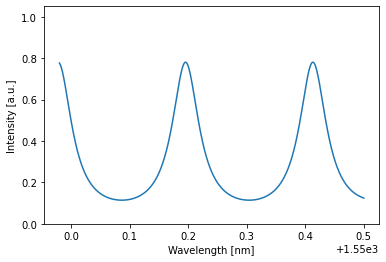

In [10]:
wavelengths = 1e-9*np.linspace(1549.98,1550.5,1000)
freq_env = pt.Environment(wl=wavelengths, freqdomain=True)
wg_phase_=0#3*np.pi/4
tr_=0.5
wg_delay_=1.02e-9
wl0_=1.55e-6
Bits=N
mzi_l1 = 1e-3
mzi_l2 = 3.88e-3
loss= 200

mzi = mzi_response(wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, loss=loss)

with freq_env:
    detected_mzi = mzi(source=1)
    
mzi.plot(detected_mzi)
#mpl.rcParams['font.family'] = 'Avenir'
#plt.rcParams['font.size'] = 12
#plt.rcParams['axes.linewidth'] = 1
#plt.xlim(1549.5e3, 1550.7e-3)
plt.ylim(0, 1.05)
plt.show()
#detected_mzi

In [11]:
'''----- BITSTREAM GENERATION -----'''
streamgen = pt.BitStreamGenerator(bitrate=Rb, samplerate=Rs, cutoff_frequency=fc, device=device)

In [12]:
'''----- BITSTREAMS -----'''

# train streams
trbits = Narma10Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
trstream = streamgen(trbits)
trtarget = streamgen(TARGET(trbits))
trtarget_np = trtarget.numpy()

# validation streams
vabits = Narma10Generator(seed=Sva)(N, 1) # N bits per validation stream, 1 validation stream per batch.
vastream = streamgen(vabits)
vatarget = streamgen(TARGET(vabits))

# test streams
tebits = Narma10Generator(seed=Ste)(N, 1) # N*B bits per teststream
testream = streamgen(tebits)
tetarget = streamgen(TARGET(tebits)) 

# Simulation time tensor
t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)

In [13]:
'''----- Mean Squared Error Function -----'''
def mse_new(target,predicted,Bits):
    mse = 0
    for i in range(target.size):
        mse = mse+(target[i] - predicted[i])**2
    mse = mse/Bits
    return mse

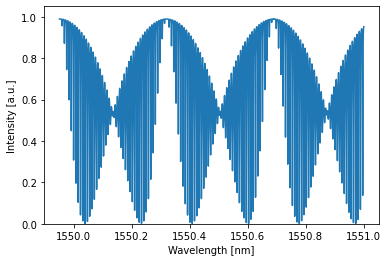

In [14]:
#Frequency Domain Response
wavelengths = 1e-9*np.linspace(1549.95,1551,10000)
freq_env = pt.Environment(wl=wavelengths, freqdomain=True)
wg_phase_=0
tr_=0.5
wg_delay_=1.02e-9
wl0_=1.55e-6
Bits=N
mzi_l1 = 1e-3
mzi_l2 = 13.12e-2  #ACTUAL FEEDBACK
mzi_fb = 3.88e-3   #MZI ARM
loss=20

ring_res_freqtest = dc_reservoir_freq(wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, mzi_fb=mzi_fb, loss=loss)


with freq_env:
    detected_freq = ring_res_freqtest(source=1)
ring_res_freqtest.plot(detected_freq)
#mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1
#plt.xlim(1549.5e3, 1550.7e-3)
plt.ylim(0, 1.05)
plt.show()
    

## Training for Narma10 Task

C:\Users\mohab\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


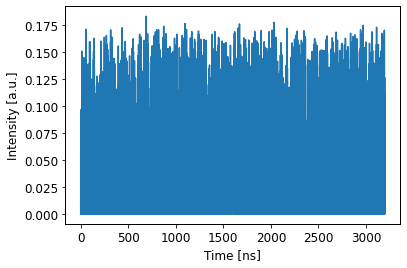

nmse: 0.1850219964147395
weights:[[ 5.9259444e-01  3.4549479e+00 -2.6005375e+01  2.3456173e+01
  -1.8068611e+01  8.2703232e+01  2.4055681e+02 -6.8581429e+01
   9.9327803e-02 -8.6252670e+00 -5.0808201e+01  1.2741890e+02
   2.3324101e+02 -1.7115115e+02 -2.0816451e+02 -1.6344896e+02
  -4.8154800e+01  7.4169159e+01 -1.3457568e+02 -1.9031497e+02
   5.3223572e+01 -4.9700603e+01 -5.1679877e+02  6.3950989e+02
   1.8983556e+02 -3.3174931e+01  3.9314873e+01 -2.0753964e+02
   7.7968849e+01  7.3994434e+02 -4.1418652e+01 -7.6439288e+02
   3.3641849e+02 -2.9935672e+02 -9.3336182e+01]]
intercept:[0.16559398]


In [15]:
'''----- Training -----'''
torch.manual_seed(5)                      #pytorch seed
wg_phase_=0
tr_=0.5
wg_delay_=1.02e-9
wl0_=1.55e-6#1.55e-6
#1.555e-6 #1.550161401e-6
Bits=N
mask_vector = torch.rand(Nodes)       #Input mask
#print(mask_vector)
mzi_l1 = 1e-3 
mzi_l2 = 13.12e-2  #ACTUAL FEEDBACK
mzi_fb = 3.88e-3   #MZI ARM
loss = 20

ring_res_test = dc_reservoir(wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, mzi_fb=mzi_fb, loss=loss)

with pt.Environment(t=t, wl0=wl0_, num_wl=1):
    detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected)
    plt.show()
        
#Data preparation -- Removing the first 200 bits
detected_np = detected.numpy()
detected_np = detected_np/np.max(detected_np)
detected_np = detected_np.reshape(Bits,Nodes)
target_now = narma10_jaeger(trbits).numpy().reshape(Bits,1)
target_now = target_now/np.max(target_now)
detected_np_cut = detected_np[200:,:]
target_now_cut = target_now[200:]

#normalized_detected = pd.DataFrame(detected_np)
#normalized_detected.to_csv('detected_np_normalized.csv')
        
#Regression and Prediction
regr = linear_model.LinearRegression()
x = regr.fit(detected_np_cut,target_now_cut)
y = regr.predict(detected_np_cut)
        
#Error Calculation
nmse = 1 - regr.score(detected_np_cut,target_now_cut)
mse = mse_new(target_now_cut,y,Bits)

print(f'nmse: {nmse}')            
print(f'weights:{regr.coef_}')
print(f'intercept:{regr.intercept_}') 

#ASYMMETRIC Length ARM2: 0.0038834064407827773

C:\Users\mohab\Anaconda3\envs\photonics\lib\site-packages\photontorch\networks\network.py:450: RuntimeWarning: Simulation timestep might be too large, resulting in zero delays for nonzero lengths. Try using a smaller timestep
  warnings.warn(


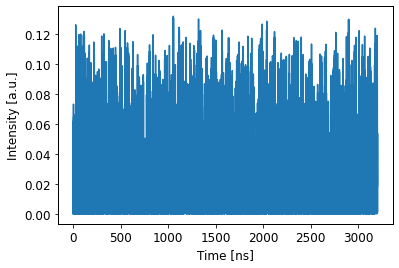

[65.23664]


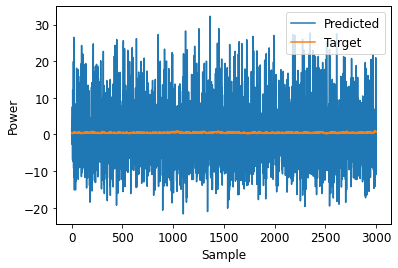

 nmse: 4006.708222385515


In [16]:
'''----- Validation Test -----'''
torch.manual_seed(5)                      #pytorch seed
wl0_va = 1.550537053705371e-6 #1.550008e-6 #1.550537053705371
with pt.Environment(t=t, wl0=wl0_va, num_wl=1):
    detected_va = ring_res_test(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    ring_res_test.plot(detected_va)
    plt.show()

#Data preparation -- Removing the first 200 bits
detected_va_np = detected_va.numpy()
detected_va_np = detected_va_np/np.max(detected_va_np)
detected_va_np = detected_va_np.reshape(Bits,Nodes)
target_va_now = narma10_jaeger(vabits).numpy().reshape(Bits,1)
target_va_now = target_va_now/np.max(target_va_now)
detected_va_np_cut = detected_va_np[200:,:]
target_va_now_cut = target_va_now[200:]


#Prediction
y_va = regr.predict(detected_va_np_cut)

#Error Calculation
nmse_va = 1 - regr.score(detected_va_np_cut,target_va_now_cut)
mse_va = mse_new(target_va_now_cut,y_va,Bits)
print(mse_va)
#Plots
plt.plot(y_va,label='Predicted')
plt.plot(target_va_now_cut,label='Target')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Power')
plt.show()

print(f' nmse: {nmse_va}') 

In [17]:
#Export to be plotted in MATLAB

#detected_freq_np = detected_freq.numpy().reshape([10000,1])
#target_data = pd.DataFrame(target_va_now_cut)
#target_data.to_csv('target.csv')
#predicted_data = pd.DataFrame(y_va)
#predicted_data.to_csv('predicted.csv')
print(np.max(detected_np))
print(np.max(detected_va_np))
print(np.max(target_now))

1.0
1.0
1.0


In [18]:
5e1

50.0

In [19]:
torch.rand(5)

tensor([0.8303, 0.1261, 0.9075, 0.8199, 0.9201])